# **Imports 📢**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

# **Inits 👶**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
mnist_dim = 28 * 28
n_g = 256
z_dim = 100
lr = 0.0002
n_epochs=400

# **Utils 🧰**

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Dataset 🎓**

In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])

In [5]:
dataset1 = MNIST(root='./mnist', train=True, download=True, transform=transform)
dataset2 = MNIST(root='./mnist', train=False, download=True, transform=T.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32508936.38it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1180556.23it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10592427.73it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1328210.89it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [6]:
dataset = ConcatDataset([dataset1, dataset2])

In [7]:
dataset1.data.shape[0]

60000

In [8]:
dataset1.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

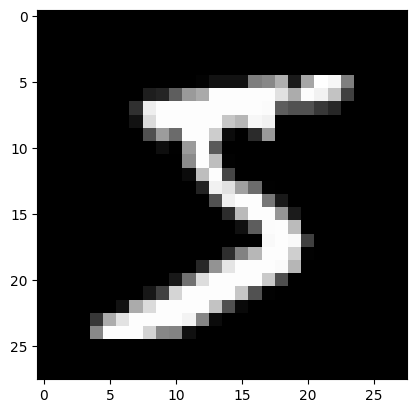

In [9]:
plt.imshow(dataset1.data[0], cmap='gray')

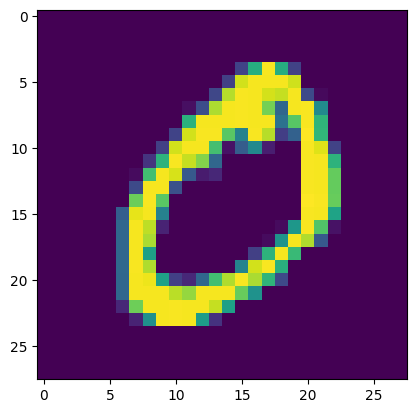

In [10]:
plt.imshow(dataset[1][0].squeeze())

In [11]:
batchsize = 100
dataloader = DataLoader(dataset1, batchsize, True)

In [12]:
x, y = next(iter(dataloader))
x.shape, y

(torch.Size([100, 1, 28, 28]),
 tensor([0, 4, 1, 0, 3, 0, 9, 9, 4, 0, 5, 3, 1, 2, 9, 9, 6, 3, 8, 4, 9, 6, 8, 4,
         8, 5, 7, 1, 0, 7, 4, 9, 2, 9, 5, 1, 0, 3, 9, 4, 6, 8, 3, 1, 7, 1, 0, 1,
         6, 5, 0, 9, 5, 4, 2, 4, 9, 7, 0, 7, 6, 4, 3, 9, 9, 4, 3, 3, 8, 2, 4, 7,
         4, 5, 6, 5, 5, 7, 9, 3, 4, 6, 1, 0, 4, 8, 9, 5, 1, 2, 4, 6, 9, 0, 1, 8,
         9, 7, 1, 1]))

In [13]:
img_grid = make_grid(x, 10)
img_grid.shape # 280 + padding = 302 # 3 channels

torch.Size([3, 302, 302])

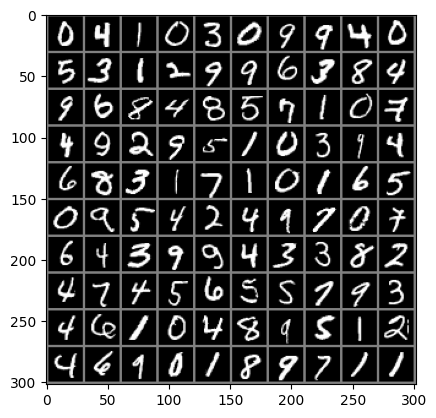

In [14]:
plt.imshow(img_grid[0], cmap='gray')

# **Models 🧠**

## Generator 💽

In [15]:
class Generator(nn.Module):
  def __init__(self, n=256):
    super(Generator, self).__init__()
    # self.layers = nn.ModuleList()
    # for l in range(nlayers):
    #   self.layers.append(nn.LazyLinear(out_features=neuron*(l+1)))

    # in = noise of each size
    self.fc1 = nn.LazyLinear(out_features=n)
    self.fc2 = nn.LazyLinear(out_features=n*2)
    self.fc3 = nn.LazyLinear(out_features=n*4)
    self.fc4 = nn.LazyLinear(out_features=mnist_dim)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    y = torch.tanh(self.fc4(x))
    return y

In [22]:
G = Generator(n_g)
G

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Generator(
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [23]:
G(torch.randn(10, z_dim)).shape

torch.Size([10, 784])

## Discriminator ⛓

In [24]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # in = 784
    self.fc1 = nn.LazyLinear(1024)
    self.fc2 = nn.LazyLinear(512)
    self.fc3 = nn.LazyLinear(256)
    self.fc4 = nn.LazyLinear(1)

  def forward(self, x):
    x = F.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), negative_slope=0.2), 0.3)
    y = torch.sigmoid(self.fc4(x))
    return y

In [25]:
D = Discriminator()
D

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [26]:
xf = x.flatten(1)

In [27]:
D(xf).shape

torch.Size([100, 1])

## Build models

In [28]:
G = Generator().to(device)
G

Generator(
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [29]:
D = Discriminator().to(device)
D

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

## **Loss & Optimizers ⏰**

In [30]:
loss_fn = nn.BCELoss()

In [31]:
G_optimizer = optim.Adam(params=G.parameters(), lr=lr)
D_optimizer = optim.Adam(params=D.parameters(), lr=lr)

# **Train 🚅**

In [32]:
# real data
x_real = x.flatten(1).to(device)
y_real = torch.ones(batchsize, 1).to(device)

# real -> D
D_output = D(x_real)
D_loss = loss_fn(D_output, y_real)

# noise & fake label
z = torch.randn(batchsize, z_dim).to(device)
y_fake = torch.zeros(batchsize, 1).to(device)

# fake data: noise -> G
x_fake = G(z)

# fake -> D
G_output = D(x_fake)
G_loss = loss_fn(G_output, y_fake)

# total loss D
D_loss = G_loss + D_loss

# optimization
D_loss.backward()
D_optimizer.step()
D_optimizer.zero_grad()

In [33]:
loss_D_hist, loss_G_hist = [], []

In [ ]:
for epoch in range(n_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  for x, _ in dataloader:
    # --------------------------------------------------------------------------
    # Discriminator
    # --------------------------------------------------------------------------
    D.zero_grad()
    # D_optimizer.zero_grad()

    # real data
    x_real = x.flatten(1).to(device)
    y_real = torch.ones(batchsize, 1).to(device)

    # real -> D
    D_output = D(x_real)
    D_loss = loss_fn(D_output, y_real)

    # noise & fake label
    z = torch.randn(batchsize, z_dim).to(device)
    y_fake = torch.zeros(batchsize, 1).to(device)

    # fake data: noise -> G
    x_fake = G(z)

    # fake -> D
    G_output = D(x_fake)
    G_loss = loss_fn(G_output, y_fake)

    # total loss D
    D_loss = G_loss + D_loss

    # optimization
    D_loss.backward()
    D_optimizer.step()

    # --------------------------------------------------------------------------
    # Generator
    # --------------------------------------------------------------------------
    G.zero_grad()
    # G_optimizer.zero_grad()

    # noise & real label
    z = torch.randn(batchsize, z_dim).to(device)
    y_real = torch.ones(batchsize, 1).to(device)

    # noise -> G -> D
    output = D(G(z))

    # loss
    G_loss = loss_fn(output, y_real)

    # optimization
    G_loss.backward()
    G_optimizer.step()

    loss_D_avg.update(D_loss.item())
    loss_G_avg.update(G_loss.item())

  loss_D_hist.append(loss_D_avg.avg)
  loss_G_hist.append(loss_G_avg.avg)

  with torch.no_grad():
    bs = 64
    z_test = torch.randn(bs, z_dim).to(device)
    output = G(z_test)
    save_image(output.view(bs, 1, 28, 28), f"./images/gan-{epoch:3d}.png")

  print(f"{epoch}/{n_epochs}: D Loss: {loss_D_avg.avg:.4f}, G Loss: {loss_G_avg.avg:.4f}")

0/400: D Loss: 1.1521, G Loss: 1.4842
1/400: D Loss: 1.1137, G Loss: 1.6624
2/400: D Loss: 0.7860, G Loss: 2.0845
3/400: D Loss: 0.6066, G Loss: 2.4296
4/400: D Loss: 0.5506, G Loss: 2.6065
5/400: D Loss: 0.5170, G Loss: 2.7407
6/400: D Loss: 0.6150, G Loss: 2.4303
7/400: D Loss: 0.6415, G Loss: 2.2371
8/400: D Loss: 0.6912, G Loss: 2.1947
9/400: D Loss: 0.7879, G Loss: 1.8913
10/400: D Loss: 0.7461, G Loss: 2.0698
11/400: D Loss: 0.7585, G Loss: 2.0099
12/400: D Loss: 0.7323, G Loss: 2.0233
13/400: D Loss: 0.7613, G Loss: 1.9589
14/400: D Loss: 0.8066, G Loss: 1.8945
15/400: D Loss: 0.8404, G Loss: 1.7909
16/400: D Loss: 0.8237, G Loss: 1.8047
17/400: D Loss: 0.8433, G Loss: 1.7665
18/400: D Loss: 0.8690, G Loss: 1.7056
19/400: D Loss: 0.9176, G Loss: 1.6062
20/400: D Loss: 0.9339, G Loss: 1.5474
21/400: D Loss: 0.9281, G Loss: 1.5563
22/400: D Loss: 0.9357, G Loss: 1.5646
23/400: D Loss: 0.9333, G Loss: 1.5500
24/400: D Loss: 0.9017, G Loss: 1.6348
25/400: D Loss: 0.9467, G Loss: 1.5

# **Evaluation ❓**

In [ ]:
with torch.no_grad():
  bs = 64
  test_z = torch.randn(bs, z_dim).to(device)
  outputs = G(test_z)
  save_image(outputs.view(bs, 1, 28, 28), f'./images/gan.png')

# **Plot 📈**

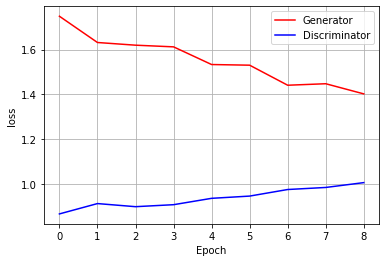

In [ ]:
plt.plot(range(epoch+1), loss_G_hist, 'r-', label='Generator')
plt.plot(range(epoch+1), loss_D_hist, 'b-', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()